# Feature 

In [25]:
import requests as rq
import json
import numpy as np
import pickle
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import snownlp
from tqdm import tqdm
from time import sleep
from bs4 import BeautifulSoup
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
from textblob import TextBlob
from snownlp import SnowNLP


<font size=6>Functions</font>

In [26]:
def print_correlation(col):
    global train
    print(f"Correlation of '{col}': {train.corr(numeric_only=True)['is_popular'][col]}")

def groupby_class(col):
    global train
    dst = col
    train[f'groupby_{col}'] = train['is_popular'].groupby(train[f'{col}']).transform('mean')
    train[f'feature_{col}'] = train[f'groupby_{col}'].apply(lambda x : round(x, 1))
    table = dict()
    for i in range(len(train)):
        table[train[f'{col}'][i]] = train[f'groupby_{col}'][i]

    with open(f'./feature/temp/{dst}.pkl', 'wb') as handle:
        pickle.dump(table, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print(table)

    
    print_correlation(f'groupby_{col}')
    print_correlation(f'feature_{col}')

def draw_lineplot(col):
    global train
    sns.lineplot(data = train.groupby(col)['is_popular'].mean(),  label='Average Popularity')
    plt.title(f'Avg Popularity ({col})', fontsize=14)

<font size=6>Read file</font>

In [27]:
train_data_path = './dataset/label/train.pkl'
save_data_path = './feature/train_feature.pkl'

train = pd.read_pickle(train_data_path)
save = True
'''
train = train.loc[train['n_comment'] != -1]
train = train.loc[train['abstract'] != '']
train = train.loc[train['abstract'] != ' ']
train = train.loc[train['abstract'] != '  ']
train = train.loc[train['headline'] != '']
train = train.drop(index = [31840, 8580, 23040, 23365, 27631, 42070, 36259])
train = train.reset_index().drop(columns=['index'])
'''
train

,web_url,print_section,print_page,news_desk,section_name,type_of_material,word_count,subsection_name,pub_year,pub_month,...,abstract_len,abstract_dup,headline,headline_len,headline_dup,headline_kicker,len_lead,keywords,authors,n_comment
0,https://www.nytimes.com/2020/12/31/opinion/202...,A,18,OpEd,Opinion,Op-Ed,882,NaN,2021,1,...,8,0,Things Will Get Better. Seriously.,5,0,None,54,"[Biden, Joseph R Jr, United States Economy, La...",[Paul Krugman],854
1,https://www.nytimes.com/2020/12/31/us/george-f...,A,17,National,U.S.,News,861,NaN,2021,1,...,29,0,Minneapolis Police Release Body Camera Video o...,13,0,None,37,"[Idd, Dolal B, Police Brutality, Misconduct an...",[Nicholas Bogel-Burroughs],0
2,https://www.nytimes.com/2020/12/31/us/resolvin...,NaN,NaN,Express,U.S.,News,263,NaN,2021,1,...,51,0,Resolving to live a lot better than in 2020.,9,0,None,51,[],[Concepción de León],0
3,https://www.nytimes.com/2020/12/31/us/politics...,NaN,NaN,Washington,U.S.,News,695,Politics,2021,1,...,29,0,Justice Dept. Asks Judge to Toss Election Laws...,10,0,None,14,"[Justice Department, Presidential Election of ...","[Maggie Haberman, Katie Benner]",0
4,https://www.nytimes.com/2020/12/31/world/the-u...,NaN,NaN,Foreign,World,News,438,NaN,2021,1,...,39,0,The U.S. reaches 20 million cases.,6,0,None,39,[internal-essential],[Kate Taylor],0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82712,https://www.nytimes.com/2022/12/31/movies/tar-...,NaN,NaN,Culture,Movies,News,1587,NaN,2022,12,...,14,0,Breaking Out of the #MeToo Movie Formula,7,0,Critic’s Notebook,116,"[#MeToo Movement, Movies, Sex Crimes, Blanchet...",[Amanda Hess],25
82713,https://www.nytimes.com/2022/12/31/opinion/bar...,NaN,NaN,OpEd,Opinion,Op-Ed,1169,NaN,2022,12,...,16,0,Katie Couric: What Barbara Walters Made Possib...,9,0,Guest Essay,22,"[Women and Girls, Television, Walters, Barbara...",[Katie Couric],0
82714,https://www.nytimes.com/2022/12/31/obituaries/...,NaN,NaN,Obits,Obituaries,News,969,NaN,2022,12,...,21,0,"Jean Franco, 98, Pioneering Scholar of Latin A...",10,0,None,41,"[Colleges and Universities, Books and Literatu...",[Clay Risen],0
82715,https://www.nytimes.com/2022/12/31/us/snowy-ow...,NaN,NaN,Express,U.S.,News,653,NaN,2022,12,...,15,0,‘Extremely Rare’ Snowy Owl Sighting Transfixes...,9,0,None,29,"[Owls, Audubon Society, National, ARCTIC REGIO...",[Michael Levenson],0


<font size=6>Set bound of popularity</font>

In [28]:
median = train['n_comment'].median()
print(f'Median: {median}')
train['is_popular'] = train['n_comment'].apply(lambda x : 1 if x > median else 0)
pop_count = 0
for i in train['is_popular']:
    if i:
        pop_count += 1
print('popular:    ' , pop_count / len(train))
print('not popular:' , 1 - pop_count / len(train))
#train = train.drop(columns = ['n_comment'])

Median: 0.0
popular:     0.2923341030259802
not popular: 0.7076658969740198


In [29]:
print(train.columns)

Index(['web_url', 'print_section', 'print_page', 'news_desk', 'section_name',
       'type_of_material', 'word_count', 'subsection_name', 'pub_year',
       'pub_month', 'pub_date', 'pub_weekday', 'pub_time', 'abstract',
       'abstract_len', 'abstract_dup', 'headline', 'headline_len',
       'headline_dup', 'headline_kicker', 'len_lead', 'keywords', 'authors',
       'n_comment', 'is_popular'],
      dtype='object')


<font size=6>Hour</font>


Correlation of 'is_noon': 0.28047677768544965


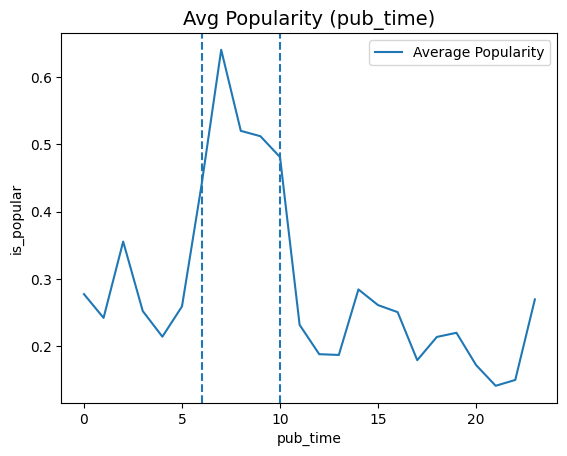

In [30]:
draw_lineplot('pub_time')
plt.axvline(x = 6, linestyle= '--')
plt.axvline(x = 10, linestyle= '--')


train['is_noon'] = train['pub_time'].apply(lambda x : 1 if (6 <= x and x <= 10) else 0)
print_correlation('is_noon')

<font size=6>Weekday</font>

Correlation of 'is_weekday': 0.046439273110494735


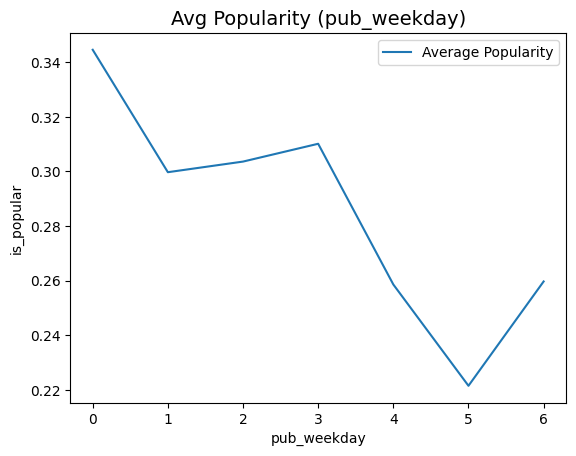

In [31]:
draw_lineplot('pub_weekday')
train['is_weekday'] = train['pub_weekday'].apply(lambda x : 1 if (x < 5) else 0)
print_correlation('is_weekday')

<font size=6>Date of month</font>

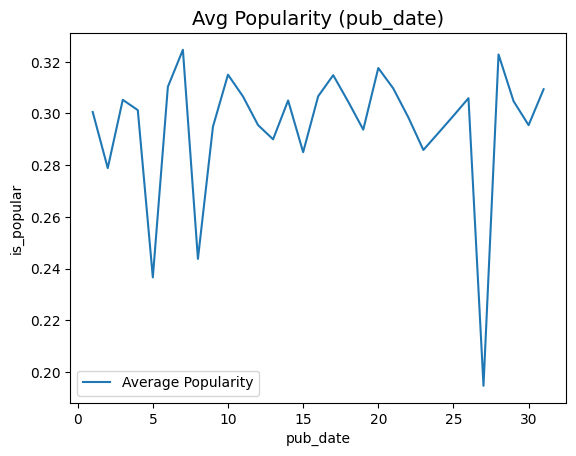

In [32]:
draw_lineplot('pub_date')

<font size=6>Month</font>

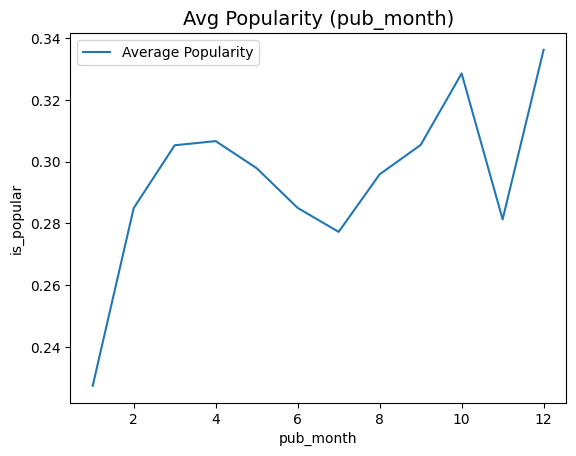

In [33]:
draw_lineplot('pub_month')

# train['is_lowmonth'] = train['pub_time'].apply(lambda x : 0 if (x <= 2) else 1)
# print_correlation('is_lowmonth'])

<font size=6>News desk</font>

In [34]:
groupby_class('news_desk')

{'OpEd': 0.5213555243633446, 'National': 0.23509102322661646, 'Express': 0.11063498246980911, 'Washington': 0.25979591836734695, 'Foreign': 0.19242685025817555, 'Games': 0.9626391096979332, 'Summary': 0.18894601542416453, 'Corrections': 0.0, 'NYTNow': 0.01026598226784881, 'Sports': 0.22632457238214435, 'Metro': 0.4130886426592798, 'Well': 0.784971098265896, 'Styles': 0.2593774940143655, 'Metropolitan': 0.6470588235294118, 'Business': 0.238562091503268, 'Arts&Leisure': 0.4835965978128797, 'Upshot': 0.9571428571428572, 'Science': 0.4175824175824176, 'Real Estate': 0.0029069767441860465, 'RealEstate': 0.8406725380304243, 'Society': 0.017857142857142856, 'Books': 0.27882037533512066, 'Dining': 0.41429369067560023, 'Politics': 0.2332535885167464, 'Culture': 0.351556420233463, 'Letters': 0.0, 'Obits': 0.1456713322965267, '': 0.0, 'SundayBusiness': 0.30939226519337015, 'AtHome': 0.02564102564102564, 'Editorial': 0.5498575498575499, 'The Upshot': 0.26153846153846155, 'BookReview': 0.1648456057

<font size=6>Section</font>

In [35]:
groupby_class('section_name')

{'Opinion': 0.46133810841608336, 'U.S.': 0.15906072678981045, 'World': 0.18362608520088836, 'Crosswords & Games': 0.956828885400314, 'Today’s Paper': 0.0035460992907801418, 'Corrections': 0.0, 'Briefing': 0.009502262443438913, 'Sports': 0.2203960396039604, 'New York': 0.4128017358285869, 'Well': 0.782051282051282, 'Style': 0.25465346534653466, 'Technology': 0.3313477289650037, 'Movies': 0.14051418439716312, 'The Upshot': 0.7055555555555556, 'Science': 0.38212180746561886, 'Real Estate': 0.5400410677618069, 'Business Day': 0.22741014444071211, 'Fashion & Style': 0.25, 'Your Money': 0.1016949152542373, 'Arts': 0.3082241630276565, 'Books': 0.2254071661237785, 'Food': 0.39767932489451474, 'Health': 0.41012909632572, 'At Home': 0.00546448087431694, 'Obituaries': 0.13636363636363635, 'Times Insider': 0.8089171974522293, 'Theater': 0.5087890625, 'The Learning Network': 0.8278529980657641, 'Homepage': 0.0, 'Travel': 0.7518656716417911, 'Podcasts': 0.46090909090909093, 'Climate': 0.426315789473

<font size=6>Subsection</font>

In [36]:
groupby_class('subsection_name')

{nan: nan, nan: nan, nan: nan, 'Politics': 0.24347689405847217, nan: nan, nan: nan, nan: nan, nan: nan, nan: nan, nan: nan, nan: nan, nan: nan, nan: nan, 'College Football': 0.20869565217391303, nan: nan, 'Live': 0.6711864406779661, nan: nan, nan: nan, 'Family': 0.92, nan: nan, 'Olympics': 0.0948905109489051, nan: nan, nan: nan, nan: nan, 'Hockey': 0.22580645161290322, nan: nan, nan: nan, nan: nan, nan: nan, 'Europe': 0.19347878206665067, nan: nan, nan: nan, nan: nan, nan: nan, nan: nan, nan: nan, 'Weddings': 0.05555555555555555, nan: nan, nan: nan, nan: nan, nan: nan, nan: nan, 'Asia Pacific': 0.25904860392967943, nan: nan, nan: nan, nan: nan, 'Soccer': 0.20272904483430798, 'Television': 0.4360655737704918, 'Music': 0.23542989036353146, nan: nan, nan: nan, 'Book Review': 0.14816535067347886, 'Self-Care': 0.38095238095238093, nan: nan, nan: nan, nan: nan, nan: nan, nan: nan, 'Letters': 0.0, nan: nan, 'Middle East': 0.2017220172201722, 'Canada': 0.10266159695817491, 'Americas': 0.254934

<font size=6>Material</font>

In [37]:
groupby_class('type_of_material')

{'Op-Ed': 0.5218074656188605, 'News': 0.32584461478054527, 'Quote': 0.0, 'Correction': 0.0, 'briefing': 0.17306155075939247, 'Interactive Feature': 0.21197648787656134, 'Slideshow': 0.0, 'Letter': 0.002004008016032064, 'Obituary (Obit)': 0.15301944728761516, 'Video': 0.0, 'Editorial': 0.48148148148148145, 'Review': 0.2582271762208068, '': 0.0, 'List': 0.012269938650306749, 'News Analysis': 0.5922330097087378, 'Biography': 0.0, "Editors' Note": 0.0}
Correlation of 'groupby_type_of_material': 0.25475892251920473
Correlation of 'feature_type_of_material': 0.2514579030075686


<font size=6>Keyword</font>

<font size=5>Politics<font size=4>( party, congress, president )</font></font>


In [38]:
train['is_party'] = train['keywords'].apply(lambda x: 1 if ('Democratic Party' in x or 'Republican Party' in x ) else 0)
train['is_congress'] = train['keywords'].apply(lambda x: 1 if ('House of Representatives' in x or 'Senate' in x) else 0)
train['is_president'] = train['keywords'].apply(lambda x: 1 if ('Trump, Donald J' in x or 'Biden, Joseph R Jr' in x)else 0)
print_correlation('is_party')
print_correlation('is_congress')
print_correlation('is_president')

Correlation of 'is_party': 0.08138369683566198
Correlation of 'is_congress': 0.014719869587907383
Correlation of 'is_president': 0.06000401398516607


<font size=5>Event <font size=4>( Ukrainian_Russian_war, covid, Storming of the US Capitol )</font></font>


In [39]:
train['is_ukrainian_russian_war'] = train['keywords'].apply(lambda x: 1 if ('War and Armed Conflicts' in x or 'Ukraine' in x ) else 0)
train['is_covid'] = train['keywords'].apply(lambda x: 1 if 'Coronavirus (2019-nCoV)' in x else 0)
train['is_storm'] = train['keywords'].apply(lambda x: 1 if 'Storming of the US Capitol (Jan, 2021)' in x else 0)
print_correlation('is_ukrainian_russian_war')
print_correlation('is_covid')
print_correlation('is_storm')

Correlation of 'is_ukrainian_russian_war': -0.011306296114816117
Correlation of 'is_covid': -0.030746851396143155
Correlation of 'is_storm': 0.023417997512603154


<font size=5>News game<font size=4>(spelling bee, crossword puzzle)</font></font>

In [40]:
train['is_spell'] = train['keywords'].apply(lambda x: 1 if 'Spelling Bee (Game)' in x else 0)
train['is_crossword'] = train['keywords'].apply(lambda x: 1 if 'Crossword Puzzles' in x else 0)
train['is_game'] = train['keywords'].apply(lambda x: 1 if 'Spelling Bee (Game)'  in x or 'Crossword Puzzles' in x else 0)
print_correlation('is_spell')
print_correlation('is_crossword')
print_correlation('is_game')

Correlation of 'is_spell': 0.11359754840716207
Correlation of 'is_crossword': 0.13177380959017243
Correlation of 'is_game': 0.17451987547561287


<font size=6>Headline length</font>

Correlation of 'headline_len': -0.03451776582744515


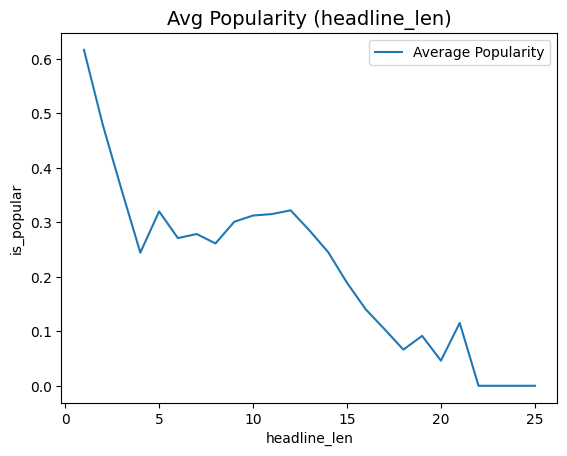

In [41]:
draw_lineplot('headline_len')
print_correlation('headline_len')

<font size=6>Abstract length</font>

Correlation of 'abstract_len': -0.008791974620138929


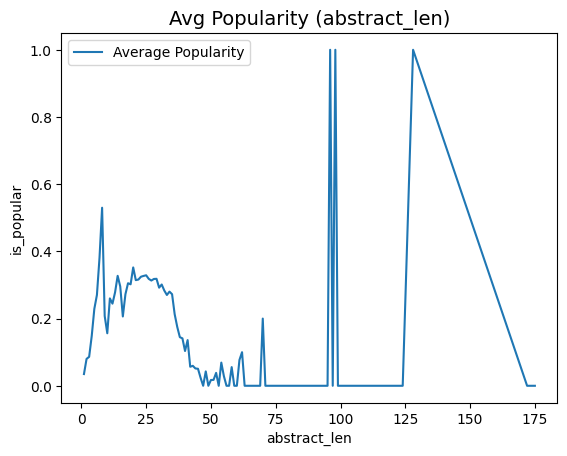

In [42]:
draw_lineplot('abstract_len')
print_correlation('abstract_len')

<font size=6>Word count</font>

Correlation of 'word_count': 0.25449032505035707


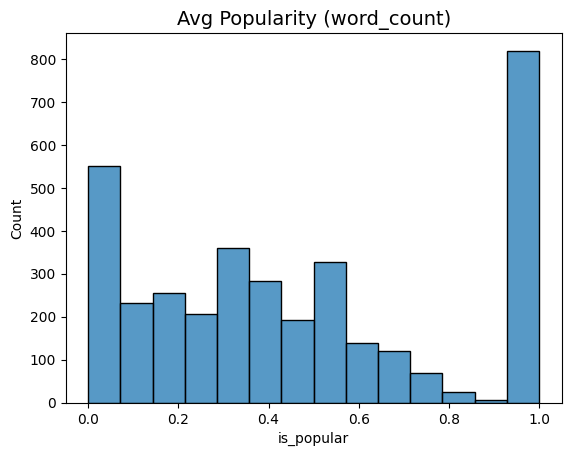

In [43]:
sns.histplot(data = train['is_popular'].groupby(train['word_count']).mean(),  label='Average Popularity')
plt.title('Avg Popularity (word_count)', fontsize=14)
print_correlation('word_count')

<font size=6>Abstract Duplication</font>

Correlation of 'abstract_dup': 0.03301590103715429


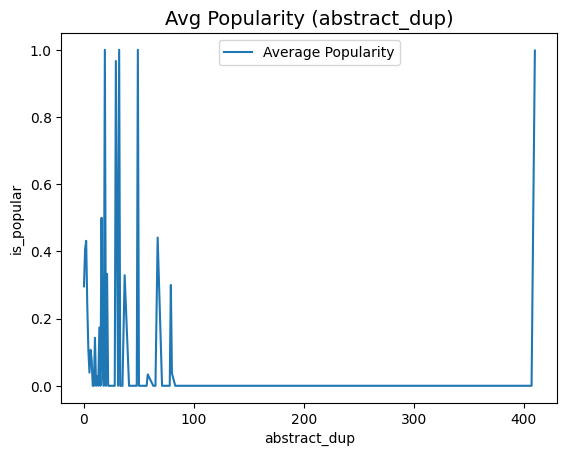

In [44]:
draw_lineplot('abstract_dup')
print_correlation('abstract_dup')

<font size=6>Lead paragraph length</font>

Correlation of 'len_lead': 0.09581048342442709


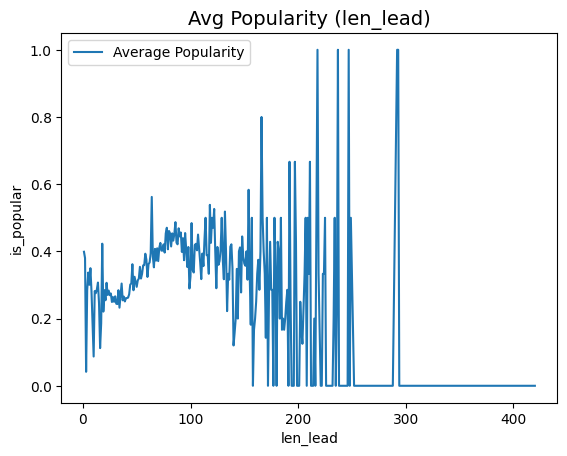

In [45]:
draw_lineplot('len_lead')
print_correlation('len_lead')

<font size = 6>Sentiment analyze</font>

<font size = 5>punctuation removal</font>

In [46]:
punct_list = list('!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~')
def remove_punctuation(headline):
    for punc in punct_list:
        if punc in headline:
            headline = headline.replace(punc, ' ')
    return headline
train['clean_headline'] = train['headline'].apply(lambda x: remove_punctuation(x))

<font size = 5>textblob</font>

In [47]:

text = "i am happy today."
blob = TextBlob(text)
# get the sentiment of the text
sentiment = blob.sentiment
print(sentiment)

Sentiment(polarity=0.8, subjectivity=1.0)


In [48]:
def tb_score_polar(headline):
    score = TextBlob(headline).sentiment[0]
    return score
def tb_score_subj(headline):
    score = TextBlob(headline).sentiment[1]
    return score
train['sentiment_tb_polar'] = train['clean_headline'].apply(lambda x : tb_score_polar(x))#-1 ~ 1
train['sentiment_tb_polar_abs'] = train['sentiment_tb_polar'].apply(lambda x :abs(x))#0 ~ 1
train['sentiment_tb_subj'] = train['clean_headline'].apply(lambda x : tb_score_subj(x))#0 ~ 1
train['sentiment_tb_pos'] = train['sentiment_tb_polar'].apply(lambda x : 1 if x > 0 else 0)#bool
print_correlation('sentiment_tb_polar')
print_correlation('sentiment_tb_polar_abs')
print_correlation('sentiment_tb_subj')
print_correlation('sentiment_tb_pos')

Correlation of 'sentiment_tb_polar': -0.0032956136662869117
Correlation of 'sentiment_tb_polar_abs': 0.0321962427095457
Correlation of 'sentiment_tb_subj': 0.03291484838662222
Correlation of 'sentiment_tb_pos': 0.0026080603853552153


<font size = 5>vader</font>

In [50]:
headline = 'today is a sunny day!'
analyzer = SentimentIntensityAnalyzer ()
sentiment_dict = analyzer.polarity_scores(headline)
print(sentiment_dict)

LookupError: 
**********************************************************************
  Resource [93mvader_lexicon[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('vader_lexicon')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93msentiment/vader_lexicon.zip/vader_lexicon/vader_lexicon.txt[0m

  Searched in:
    - 'C:\\Users\\ChuanYu/nltk_data'
    - 'd:\\anaconda3\\envs\\ai-final\\nltk_data'
    - 'd:\\anaconda3\\envs\\ai-final\\share\\nltk_data'
    - 'd:\\anaconda3\\envs\\ai-final\\lib\\nltk_data'
    - 'C:\\Users\\ChuanYu\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
    - ''
**********************************************************************


In [51]:
train['sentiment_vader_neg'] = train['clean_headline'].apply(lambda x : analyzer.polarity_scores(x)['neg'])#0 ~ 1
train['sentiment_vader_neu'] = train['clean_headline'].apply(lambda x : analyzer.polarity_scores(x)['neu'])#0 ~ 1
train['sentiment_vader_pos'] = train['clean_headline'].apply(lambda x : analyzer.polarity_scores(x)['pos'])#0 ~ 1
train['sentiment_vader_compound'] = train['clean_headline'].apply(lambda x : analyzer.polarity_scores(x)['compound'])#-1 ~ 1
train['sentiment_vader_compound_abs'] = train['sentiment_vader_compound'].apply(lambda x : abs(x))#0 ~ 1
print_correlation('sentiment_vader_neg')
print_correlation('sentiment_vader_neu')
print_correlation('sentiment_vader_pos')
print_correlation('sentiment_vader_compound')
print_correlation('sentiment_vader_compound_abs')

NameError: name 'analyzer' is not defined

<font size = 5>snownlp</font>

In [ ]:
headline = 'i am happy'
sentence = 'hello","why is it not working?!'
s = SnowNLP(headline)
print(s.sentiments)

In [ ]:
train['sentiment_snow'] = train['clean_headline'].apply(lambda x : SnowNLP(x).sentiments)#0 ~ 1
train['sentiment_snow_abs'] = train['sentiment_snow'].apply(lambda x : 2 * abs(x - 0.5))#-1 ~ 1
train['sentiment_snow_pos'] = train['sentiment_snow'].apply(lambda x : 1 if x > 0.5 else 0)#bool
print_correlation('sentiment_snow')
print_correlation('sentiment_snow_abs')
print_correlation('sentiment_snow_pos')

<font size = 6>abstract</font>

In [ ]:

train['clean_abstract'] = train['abstract'].apply(lambda x: remove_punctuation(x))

<font size = 5>textblob</font>

In [ ]:
def tb_score_polar(headline):
    score = TextBlob(headline).sentiment[0]
    return score
def tb_score_subj(headline):
    score = TextBlob(headline).sentiment[1]
    return score
train['sentiment_abstract_tb_polar'] = train['clean_abstract'].apply(lambda x : tb_score_polar(x))#-1 ~ 1
train['sentiment_abstract_tb_polar_abs'] = train['sentiment_abstract_tb_polar'].apply(lambda x :abs(x))#0 ~ 1
train['sentiment_abstract_tb_subj'] = train['clean_abstract'].apply(lambda x : tb_score_subj(x))#0 ~ 1
train['sentiment_abstract_tb_pos'] = train['sentiment_abstract_tb_polar'].apply(lambda x : 1 if x > 0 else 0)#bool
print_correlation('sentiment_abstract_tb_polar')
print_correlation('sentiment_abstract_tb_polar_abs')
print_correlation('sentiment_abstract_tb_subj')
print_correlation('sentiment_abstract_tb_pos')

<font size = 5>vader</font>

In [ ]:
train['sentiment_abstract_vader_neg'] = train['clean_abstract'].apply(lambda x : analyzer.polarity_scores(x)['neg'])#0 ~ 1
train['sentiment_abstract_vader_neu'] = train['clean_abstract'].apply(lambda x : analyzer.polarity_scores(x)['neu'])#0 ~ 1
train['sentiment_abstract_vader_pos'] = train['clean_abstract'].apply(lambda x : analyzer.polarity_scores(x)['pos'])#0 ~ 1
train['sentiment_abstract_vader_compound'] = train['clean_abstract'].apply(lambda x : analyzer.polarity_scores(x)['compound'])#-1 ~ 1
train['sentiment_abstract_vader_compound_abs'] = train['sentiment_vader_compound'].apply(lambda x : abs(x))#0 ~ 1
print_correlation('sentiment_abstract_vader_neg')
print_correlation('sentiment_abstract_vader_neu')
print_correlation('sentiment_abstract_vader_pos')
print_correlation('sentiment_abstract_vader_compound')
print_correlation('sentiment_abstract_vader_compound_abs')

<font size = 5>snownlp</font>

In [ ]:
train['sentiment_abstract_snow'] = train['clean_abstract'].apply(lambda x : SnowNLP(x).sentiments)#0 ~ 1
train['sentiment_abstract_snow_abs'] = train['sentiment_abstract_snow'].apply(lambda x : 2 * abs(x - 0.5))#-1 ~ 1
train['sentiment_abstract_snow_pos'] = train['sentiment_abstract_snow'].apply(lambda x : 1 if x > 0.5 else 0)#bool
print_correlation('sentiment_abstract_snow')
print_correlation('sentiment_abstract_snow_abs')
print_correlation('sentiment_abstract_snow_pos')

In [ ]:
train = train.drop(columns=['web_url', 'print_section', 'print_page', 'pub_year',
       'abstract','abstract_dup', 'headline', 
       'headline_dup', 'headline_kicker', 'pub_weekday'])

In [ ]:
fea_list = train.corr()['is_popular']
fea_list = fea_list.sort_values(key = lambda x : abs(x), ascending=False)
print(fea_list)

In [ ]:
suit_attribute = []
for i in range(40):
    suit_attribute.append(fea_list.index[i])
for col in train.columns:
    if col not in suit_attribute:
        train = train.drop(columns = col)
        print(col)
        
#print(list.columns)
#list.sort_values(list, key = lambda x: x[1])
#print(list)

In [ ]:
print(train.corr()['is_popular'])

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(train.corr(), cmap='coolwarm', annot=False, square=True, fmt='.2f', cbar=True, center=0)

In [ ]:
train = train.drop(columns = 'n_comment')
'''
train = train.drop(columns=['group_by_news_desk', 'group_by_section_name', 'group_by_subsection_name',
                            'group_by_type_of_material', 'feature_news_desk', 'feature_subsection_name',
                           'sentiment_abstract_snow', 'sentiment_abstract_vader_compound', 'sentiment_vader_compound', 
                           'sentiment_abstract_vader_neu', 'is_game',  'sentiment_abstract_tb_pos'])
train.columns
'''


In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(train.corr(), cmap='coolwarm', annot=False, square=True, fmt='.2f', cbar=True, center=0)

In [ ]:
plt.figure(figsize=(10,12))
sns.heatmap(train.corr()[['is_popular']].sort_values(ascending=False, by='is_popular'), 
            cmap='coolwarm', annot=True, vmax=0.8, center=0)

# Check the features

In [ ]:
# if save:
#     train.to_pickle(f'./feature/{feat_data}.pkl')
# feat = pd.read_pickle(f'./feature/{feat_data}.pkl')
# feat

Index([ 'print_section', 'print_page', 'pub_year',
       'abstract','abstract_dup', 'headline', 
       'headline_dup', 'headline_kicker', 'len_lead', 
       'is_popular'],
      dtype='object')